In [1]:
# This notebook illustrates example outputs from Funman, and how to work with the ParameterSpace object it creates.

# The file scratch/hackathon/hackathon_fall_2023_demo_terarrium.py was used to generate the outputs rendered here.

SAVED_RESULTS_DIR = "./out"

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman_demo.example.pde import plot_spatial_timeseries
from IPython.display import HTML
import matplotlib.pyplot as plt
import itertools
from funman import FunmanWorkRequest, EncodingSchedule

import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
from funman import FUNMANConfig
import logging
from funman_demo import summarize_results



RESOURCES = "../resources"
EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "terrarium-tests")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR,"seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "seird_request.json"
)


# EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "stratified")
# MODEL_PATH = os.path.join(
#     EXAMPLE_DIR,"model_amr.json"
# )
# REQUEST_PATH = os.path.join(
#     EXAMPLE_DIR, "model_amr_request.json"
# )


# %load_ext autoreload
# %autoreload 2

In [2]:
# Feb 2024 Hackathon Scenario 3 (SEIRD)

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "mira")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "models", "scenario_3_seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "requests", "scenario_3_seird_request.json"
)


N = "Total_population"
STATES = ["Susceptible", "Exposed", "Infected", "Recovered", "Deceased"]
COMPARTMENTS = STATES + [N]

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=list(range(0, 80, 10)))

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.001
    funman_request.config.verbosity = 5
    funman_request.config.dreal_log_level = "trace"

    factor = 1
    to_synthesize = ["beta", "gamma"]
    for p in [po for po in funman_request.parameters if po.name not in []]:
        param = funman_request.parameter(p.name)
        param.interval.lb = max(p.interval.lb-factor, min(0, p.interval.lb))
        param.interval.ub = min(p.interval.ub+factor, max(1, p.interval.ub))
        # param.label = "all" if p.name in to_synthesize else "any"

    # # Susceptible is decreasing,  dS/dt < 0, S_{t+1} - S_t < 0
    # c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0), variables=["Susceptible"], derivative=True, timepoints=Interval(lb=10))
    # funman_request.constraints.append(c1)

    # # R is increasing, dR/dt > 0, -dR/dt < 0,   - (R_{t+1} - R_t) < 0
    c2 = LinearConstraint(name="c2", additive_bounds=Interval(ub=0), variables=["Recovered"], weights=[-1], derivative=True, timepoints=Interval(lb=20))
    funman_request.constraints.append(c2)

    # # D is increasing, dD/dt > 0, -dD/dt < 0,   - (D_{t+1} - D_t) < 0
    c3 = LinearConstraint(name="c3", additive_bounds=Interval(ub=0), variables=["Deceased"], weights=[-1], derivative=True,  timepoints=Interval(lb=20))
    funman_request.constraints.append(c3)

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=COMPARTMENTS, weights=[1, 1, 1, 1, 1, -1])
    funman_request.constraints.append(c4)

    # # Infected peak
    # c5 = LinearConstraint(name="Infected_peak", additive_bounds=Interval(lb=50), variables=["Infected"], timepoints=Interval(lb=40, ub=40, closed_upper_bound=True))
    # funman_request.constraints.append(c5)

    for sv in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{sv}_bounds", variable=sv, interval=Interval(lb=0, ub=100, closed_upper_bound=True)))
    

    


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(COMPARTMENTS, results_unconstrained_point, ylabel="Population", synthesized_parameters=to_synthesize+["timestep"])
    print(summary)

Automatic initialization of gaol... done
2024-02-29 17:38:14,367 - /home/danbryce/funman/src/funman/search/smt_check.py - DEBUG - Solving schedule: timepoints=[0, 10, 20, 30, 40, 50, 60, 70]
2024-02-29 17:38:14,373 - funman_dreal.solver - DEBUG - Created new Solver ...
[debug] [20240229 17:38:14.372716] SatSolver::Set Default Phase Jeroslow-Wang
[debug] [20240229 17:38:14.373934] ContextImpl::SetLogic(QF_NRA)
2024-02-29 17:38:14,388 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 0 to 10
2024-02-29 17:38:14,453 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 10 to 20
2024-02-29 17:38:14,500 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 20 to 30
2024-02-29 17:38:14,542 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 30 to 40
2024-02-29 17:38:14,586 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 40 to 50
2024-02-29 17

KeyboardInterrupt: 

2024-02-29 21:24:45,355 - funman.server.worker - INFO - FunmanWorker running...
2024-02-29 21:24:45,359 - funman.server.worker - INFO - Starting work on: 017f127c-85c3-4351-967c-5948fa68e16c
2024-02-29 21:24:47,374 - funman.api.run - INFO - Dumping results to ./out/017f127c-85c3-4351-967c-5948fa68e16c.json
2024-02-29 21:24:57,533 - funman.api.run - INFO - Dumping results to ./out/017f127c-85c3-4351-967c-5948fa68e16c.json
2024-02-29 21:24:57,534 - funman.scenario.consistency - INFO - 3{30}:	[+]
2024-02-29 21:24:57,538 - funman.server.worker - INFO - Completed work on: 017f127c-85c3-4351-967c-5948fa68e16c
2024-02-29 21:25:07,557 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-02-29 21:25:07,610 - funman.server.worker - INFO - FunmanWorker exiting...
2024-02-29 21:25:07,612 - funman.server.worker - INFO - Worker.stop() completed.


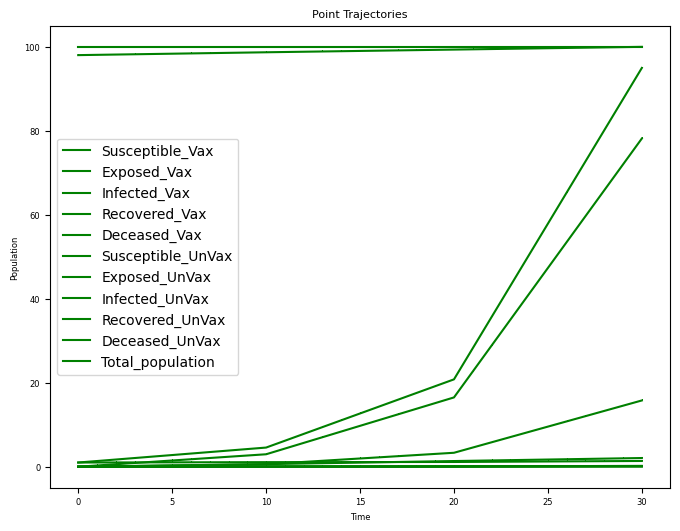

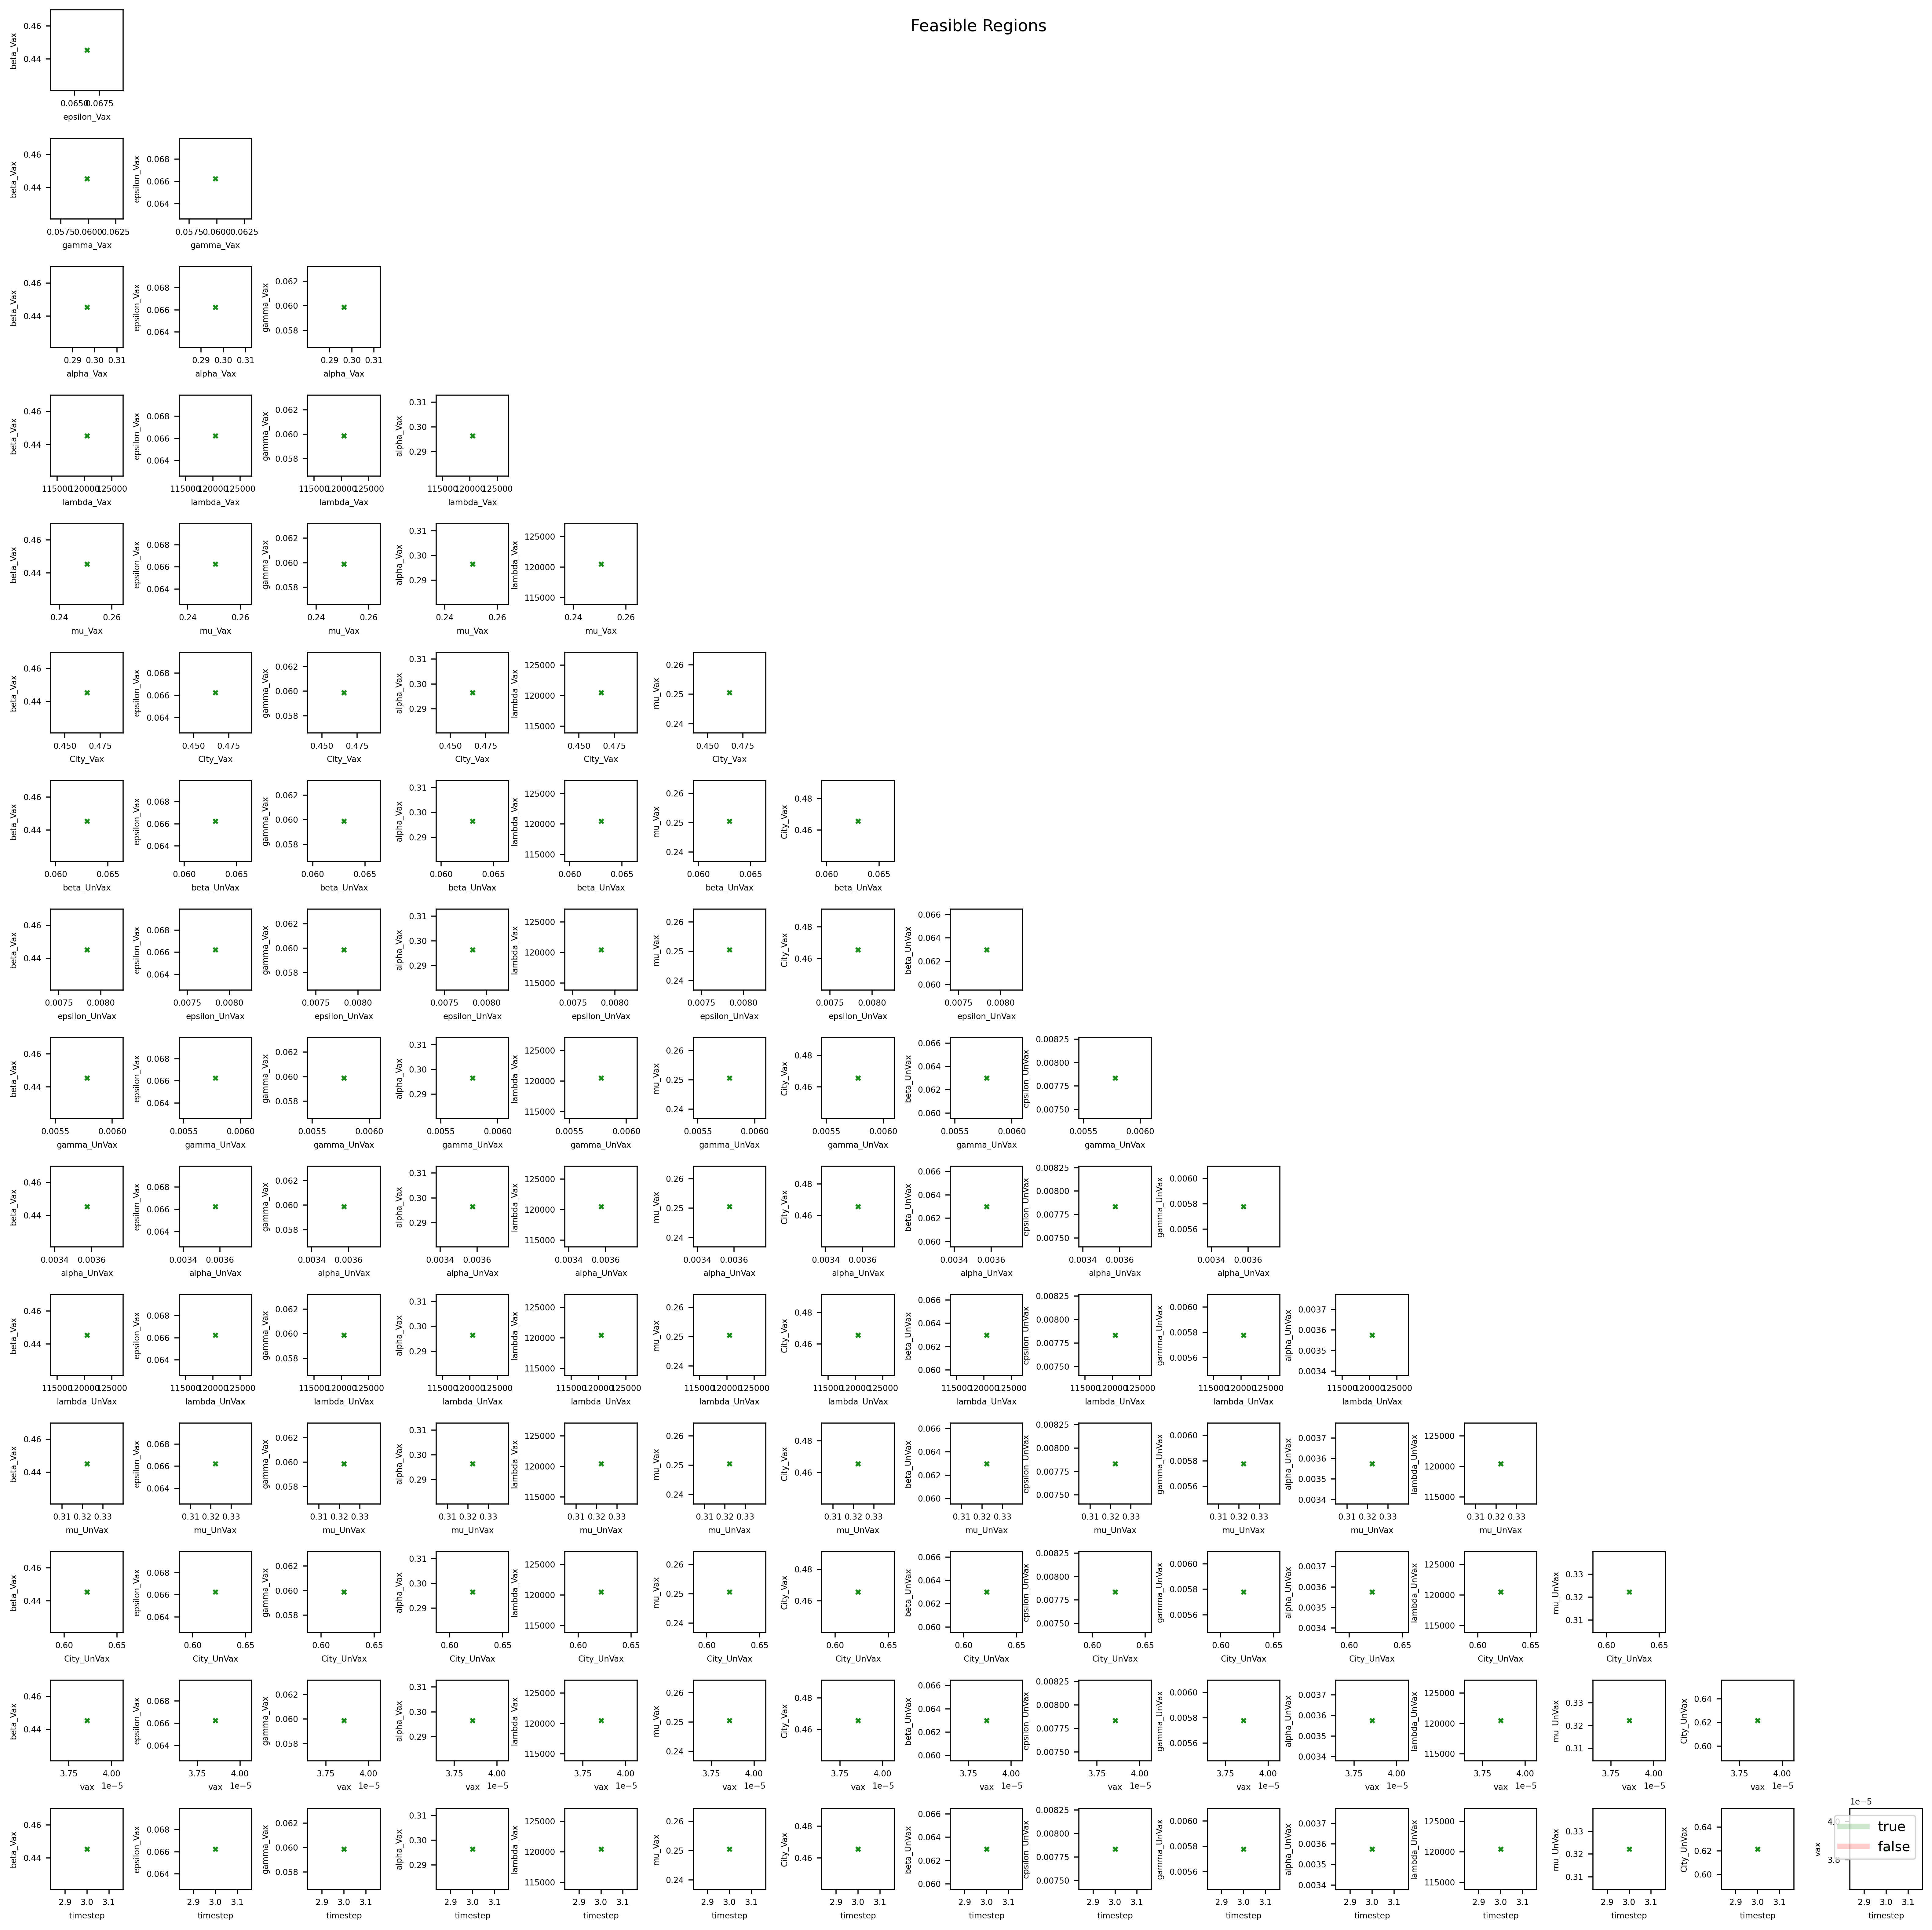

********************************************************************************
********************************************************************************
* Analysis Summary
********************************************************************************
1 Points (+:1, -:0), 1 Boxes (+:1, -:0)
Parameters = {beta_Vax[0, 1): 0.4453534983804695, epsilon_Vax[0, 1): 0.06624610675240795, gamma_Vax[0, 1): 0.05988505015839595, alpha_Vax[0, 1): 0.2964957511831101, lambda_Vax[120479.0, 120480.0): 120479.83044612847, mu_Vax[0, 1): 0.2505640417704365, City_Vax[0.0, 1): 0.46563548227601725, beta_UnVax[0, 1): 0.06299627847602818, epsilon_UnVax[0, 1): 0.007834865822290489, gamma_UnVax[0, 1): 0.005778689565612592, alpha_UnVax[0, 1): 0.0035753670295190676, lambda_UnVax[120479.0, 120480.0): 120479.61231795441, mu_UnVax[0, 1): 0.32224283954099525, City_UnVax[0.0, 1): 0.6215976986452335, vax[0, 1): 3.856237644681446e-05}
        # {beta_Vax[0, 1): 0.4453534983804695, epsilon_Vax[0, 1): 0.0662461067

In [38]:
# Feb 2024 Hackathon Scenario 3 (SEIRD)

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "mira")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "models", "scenario_3_seird_stratified.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "requests", "scenario_3_seird_request_stratified.json"
)


N = "Total_population"
STATES_Vax = ["Susceptible_Vax", "Exposed_Vax", "Infected_Vax", "Recovered_Vax", "Deceased_Vax"]
STATES_UnVax = ["Susceptible_UnVax", "Exposed_UnVax", "Infected_UnVax", "Recovered_UnVax", "Deceased_UnVax"]
STATES = STATES_UnVax + STATES_Vax
COMPARTMENTS = STATES_Vax + STATES_UnVax + [N]


with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=list(range(0, 40, 10)))

    # funman_request.config.substitute_subformulas = True
    funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.001
    # funman_request.config.verbosity = 5
    # funman_request.config.dreal_log_level = "trace"

    factor = 1
    to_synthesize = ["beta_Vax", "gamma_Vax"]
    for p in [po for po in funman_request.parameters if po.name not in []]:
        param = funman_request.parameter(p.name)
        param.interval.lb = max(p.interval.lb-factor, min(0, p.interval.lb))
        param.interval.ub = min(p.interval.ub+factor, max(1, p.interval.ub))
        # param.label = "all" if p.name in to_synthesize else "any"

    # dVax/dt > 0  -(Vax_{t+1}-Vax_t) < 0
    inc_vax = LinearConstraint(name="inc_vax", additive_bounds=Interval(ub=0), variables=STATES_Vax, derivative=True, weights=[-1]*len(STATES_Vax))
    funman_request.constraints.append(inc_vax)

    # dUnVax/dt < 0  (UnVax_{t+1}-UnVax_t) < 0
    dec_unvax = LinearConstraint(name="dec_unvax", additive_bounds=Interval(ub=0), variables=STATES_UnVax, derivative=True)
    # funman_request.constraints.append(dec_unvax)

    # # Susceptible is decreasing,  dS/dt < 0, S_{t+1} - S_t < 0
    # c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0), variables=["Susceptible_UnVax"], derivative=True, timepoints=Interval(lb=0))
    # funman_request.constraints.append(c1)

    # # # R is increasing, dR/dt > 0, -dR/dt < 0,   - (R_{t+1} - R_t) < 0
    # c2 = LinearConstraint(name="c2", additive_bounds=Interval(ub=0), variables=["Recovered_Vax"], weights=[-1], derivative=True, timepoints=Interval(lb=0))
    # funman_request.constraints.append(c2)

    # # # D is increasing, dD/dt > 0, -dD/dt < 0,   - (D_{t+1} - D_t) < 0
    # c3 = LinearConstraint(name="c3", additive_bounds=Interval(ub=0), variables=["Deceased_Vax"], weights=[-1], derivative=True,  timepoints=Interval(lb=0))
    # funman_request.constraints.append(c3)

    # # Population size maintained
    # c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=COMPARTMENTS, weights=[1, 1, 1, 1, 1, -1])
    # funman_request.constraints.append(c4)

    # # Infected peak
    # c5 = LinearConstraint(name="Infected_peak", additive_bounds=Interval(lb=50), variables=["Infected"], timepoints=Interval(lb=40, ub=40, closed_upper_bound=True))
    # funman_request.constraints.append(c5)

    for sv in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{sv}_bounds", variable=sv, interval=Interval(lb=0, ub=100, closed_upper_bound=True)))
    

    


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(COMPARTMENTS, results_unconstrained_point, ylabel="Population", synthesized_parameters=to_synthesize+["timestep"])
    print(summary)

In [40]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[COMPARTMENTS]
# df["S"]+df["E"]+df["I"]+df["D"]

,Susceptible_Vax,Exposed_Vax,Infected_Vax,Recovered_Vax,Deceased_Vax,Susceptible_UnVax,Exposed_UnVax,Infected_UnVax,Recovered_UnVax,Deceased_UnVax,Total_population
time,,,,,,,,,,,
0.0,0.000000,0.000000,1.000000,0.000000,0.000000,98.000000,0.000000,1.000000,0.000000,0.000000,100.0
1.0,0.003927,0.000000,1.356034,0.059885,0.296522,98.067806,0.061736,1.008657,0.005929,0.003575,100.0
2.0,0.007854,0.000000,1.712068,0.119770,0.593045,98.135612,0.123473,1.017314,0.011858,0.007151,100.0
3.0,0.011781,0.000000,2.068102,0.179655,0.889567,98.203418,0.185209,1.025971,0.017787,0.010726,100.0
4.0,0.015708,0.000000,2.424135,0.239540,1.186089,98.271224,0.246945,1.034628,0.023716,0.014301,100.0
5.0,0.019635,0.000000,2.780169,0.299425,1.482612,98.339030,0.308682,1.043286,0.029645,0.017877,100.0
6.0,0.023562,0.000000,3.136203,0.359310,1.779134,98.406836,0.370418,1.051943,0.035574,0.021452,100.0
7.0,0.027490,0.000000,3.492237,0.419195,2.075657,98.474642,0.432154,1.060600,0.041503,0.025028,100.0
8.0,0.031417,0.000000,3.848271,0.479080,2.372179,98.542448,0.493891,1.069257,0.047432,0.028603,100.0


In [22]:
# results_unconstrained_point.parameter_space.points()[0]
# df= results_unconstrained_point.dataframe(
#     results_unconstrained_point.parameter_space.points()
# )
# df[COMPARTMENTS].describe() #.plot()
results_unconstrained_point.parameter_space.false_boxes[0].explanation.expression

'((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((solve_step_0 & assume_Deceased_bounds) & assume_Recovered_bounds) & assume_Infected_bounds) & assume_Exposed_bounds) & assume_Susceptible_bounds) & assume_compartment) & disj1095) & (alpha <= 10060000000000001/10000000000000000)) & (epsilon <= 2666666666666667/2000000000000000)) & solve_step_2) & solve_step_1) & disj1109) & assume_c3_20) & assume_c2_20) & disj1129) & disj1132) & (beta < 6823503167783207/25000000000000000)) & (gamma < 1/512)) & ((conj1471 | (! assume_Infected_bounds)) | (! disj1092))) & (disj1092 | (! conj1474))) & ((conj1472 | (! assume_Susceptible_bounds)) | (! disj1093))) & (disj1093 | (! conj1474))) & ((conj1474 | (! solve_step_0)) | (! disj1095))) & ((Deceased_0 = 0.0) | (! conj1474))) & ((Recovered_0 = 0.0) | (! conj1474))) & ((Exposed_0 = 0.0) | (! conj1474))) & (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((Infected_0 < 0.0) | (Sus

In [23]:
import textwrap
expr = results_unconstrained_point.parameter_space.false_boxes[0].explanation.expression
print(textwrap.fill(expr, 80))


((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
((((((((((((((((((((((((((((((((((((solve_step_0 & assume_Deceased_bounds) &
assume_Recovered_bounds) & assume_Infected_bounds) & assume_Exposed_bounds) &
assume_Susceptible_bounds) & assume_compartment) & disj1095) & (alpha <=
10060000000000001/10000000000000000)) & (epsilon <=
2666666666666667/2000000000000000)) & solve_step_2) & solve_step_1) & disj1109)
& assume_c3_20) & assume_c2_20) & disj1129) & disj1132) & (beta <
6823503167783207/25000000000000000)) & (gamma < 1/512)) & ((conj1471 | (!
assume_Infected_bounds)) | (! disj1092))) & (disj1092 | (! conj1474))) &
((conj1472 | (! assume_Susceptible_bounds)) | (! disj1093))) & (disj1093 | (!
conj1474))) & ((conj1474 | (! solve_step_0)) | (! disj1095))) & ((Deceased_0 =
0.0) | (! conj1474))) & ((Recovered_0 = 0.0) | (! conj1474))) & ((Exposed_0 =
0.0) | (! conj1474))) &
(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((Infected_0 < 0.0)
| (Sus

In [ ]:
# SEIRHD

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0, 1])

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"

    for p in [po.name for po in funman_request.parameters if po.name not in ["S0", "I0", "E0", "R0", "H0", "D0", "N", "beta"]]:
    #["beta", "r_H_to_D", "r_E_to_I", "p_I_to_R", "r_I_to_R",  "p_I_to_H", "r_I_to_H", "p_H_to_R", "r_H_to_R","p_H_to_D","r_H_to_D"]:
        param = funman_request.parameter(p)
        param.interval.lb = 0
        param.interval.ub = 1

    # S is decreasing,  dS/dt < 0, S_{t+1} - S_t < 0
    c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0), variables=["S"], derivative=True)
    funman_request.constraints.append(c1)

    # R is increasing, dR/dt > 0, -dR/dt < 0,   - (R_{t+1} - R_t) < 0
    c2 = LinearConstraint(name="c2", additive_bounds=Interval(ub=0), variables=["R"], weights=[-1], derivative=True)
    funman_request.constraints.append(c2)

    # D is increasing, dD/dt > 0, -dD/dt < 0,   - (D_{t+1} - D_t) < 0
    c3 = LinearConstraint(name="c3", additive_bounds=Interval(lb=0), variables=["D"], derivative=True)
    funman_request.constraints.append(c3)

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=["S", "E", "I", "R", "D", "H", "N"], weights=[1, 1, 1, 1, 1, 1, -1])
    funman_request.constraints.append(c4)

    funman_request.constraints.append(StateVariableConstraint(name="SB", variable="S", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="EB", variable="E", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="IB", variable="I", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="RB", variable="R", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="DB", variable="D", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="HB", variable="H", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(["S", "E", "I", "R", "H", "D"], results_unconstrained_point, ylabel="Population")
    print(summary)

In [9]:
json.loads(c2.model_dump_json())

{'soft': True,
 'name': 'c2',
 'timepoints': None,
 'additive_bounds': {'lb': -1.7976931348623157e+308,
  'ub': 0.0,
  'closed_upper_bound': False,
  'original_width': 1.7976931348623157e+308},
 'variables': ['R'],
 'weights': [-1],
 'derivative': True}

In [ ]:
import json
json.loads(results_unconstrained_point.parameter_space.false_boxes[0].explanation.model_dump_json())#['relevant_assumptions']

In [ ]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[["S", "E", "I", "R", "H", "D"]]
# df["S"]+df["E"]+df["I"]+df["D"]

In [ ]:
# Stratified

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0,1, 2])
    funman_request.config.substitute_subformulas = True
    funman_request.config.use_transition_symbols = True
#     funman_request.config.use_compartmental_constraints=False
#     r_H_to_D = funman_request.parameter("r_H_to_D")
#     r_H_to_D.interval.lb = 0
#     r_H_to_D.interval.ub = 1.0

    # r_E_to_I = funman_request.parameter("r_E_to_I")
    # r_E_to_I.interval.lb = 0
    # r_E_to_I.interval.ub = 1.0


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    # summary = summarize_results(["S", "E", "I", "R", "D"], results_unconstrained_point, ylabel="Population")
    # print(summary)

In [ ]:
results_unconstrained_point.parameter_space.points()[0]